In [1]:
import os
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import librosa
import seaborn as sns

import matplotlib.pyplot as plt
from librosa.display import specshow

import IPython.display as ipd
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from scipy import signal
from scipy.stats import entropy
from numpy.linalg import norm
from scipy.spatial.distance import pdist
from scipy.stats import norm
from umap import UMAP
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

%matplotlib inline

In [2]:
def JSD(P, Q):
    _P = P / np.linalg.norm(P, ord=1)
    _Q = Q / np.linalg.norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return 0.5 * (entropy(_P, _M) + entropy(_Q, _M))

def jaccard(x, y):
    return 1-np.minimum(x, y).sum()

# Introduction

In the previous Notebook, we tried to directly use Neural Network on the full FFT. This gaves bad result. Then we tried to slice the music is 0.5s pieces and create a Covariance Matrix for both pieces and feed this to a RNN. this gave better result but still low (45% of accuracy with only 8 classes). Now we will explore another way to classify song with more simple model. 

The first thing is to extract frequency histogram for each beats. This can be used like we do with SIFT descriptor. Then we can do a clustering of those features to do after a BoW of audio features for each samples. This after can be proceed like proceed with text data.

# Presentation

As it is well explained on <a href="https://www.youtube.com/watch?v=Cl-m4X3rwac">this video</a>, there is another way to extract music features which is the Constant Q Transform. This is what we will is in correlation with beats to slice every song. First let's look at it on one example.

In [3]:
base_song_path = "fma_small/000/000005.mp3"

In [4]:
y, sr = librosa.load(base_song_path, sr=None, mono = True)

if sr != 44100:
    y = librosa.resample(y, sr, 44100)
    sr = 44100
    
D = librosa.stft(y, 
                 n_fft = 1024, 
                 hop_length = 1024, # hop_length = 20 ms
                 win_length = 1024,
                 window = signal.tukey(1024),
                ) 
    
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, hop_length=1024)
beat_times = librosa.frames_to_time(beats, sr=sr, hop_length=1024)
cqt = np.abs(librosa.cqt(y, sr=sr, hop_length=1024))
subseg = librosa.segment.subsegment(cqt, beats, n_segments=1)
subseg_t = librosa.frames_to_time(subseg, sr=sr, hop_length=1024)

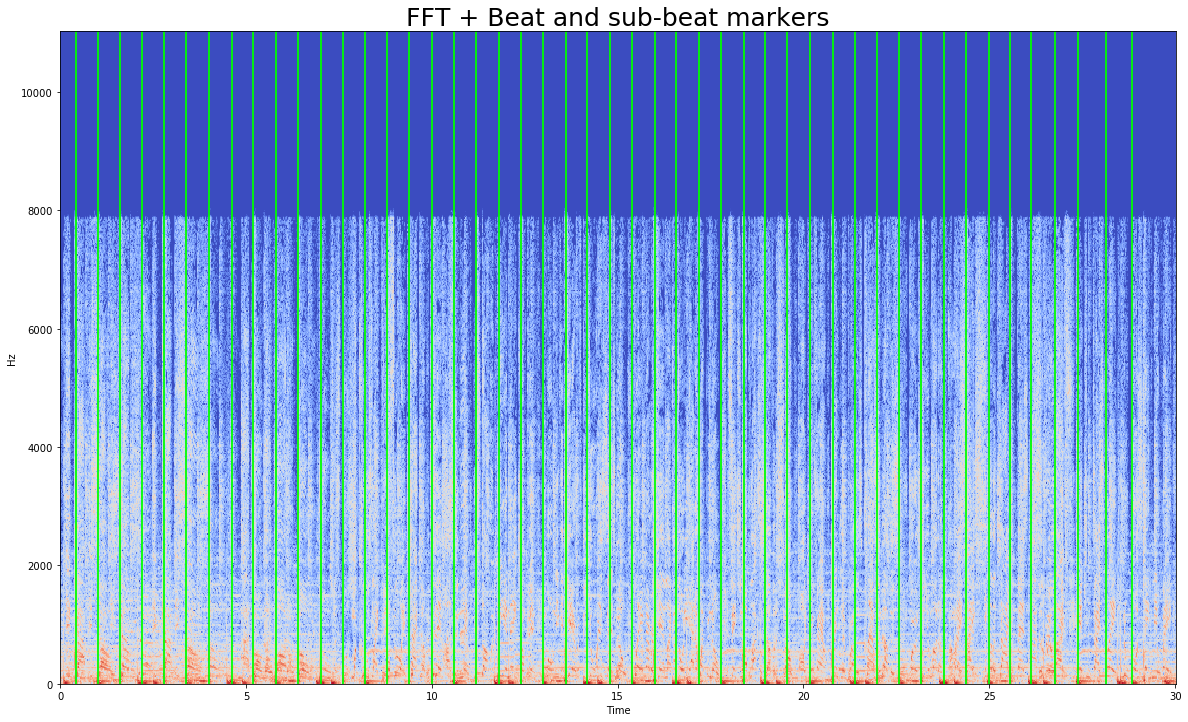

In [5]:
plt.figure(figsize=(20,12))
specshow(librosa.amplitude_to_db(np.abs(D)), y_axis='hz', x_axis='time')
lims = plt.gca().get_ylim()
plt.vlines(beat_times, lims[0], lims[1], color='lime', alpha=0.9, linewidth=2, label='Beats')
plt.title('FFT + Beat and sub-beat markers', fontsize=25)
plt.show()

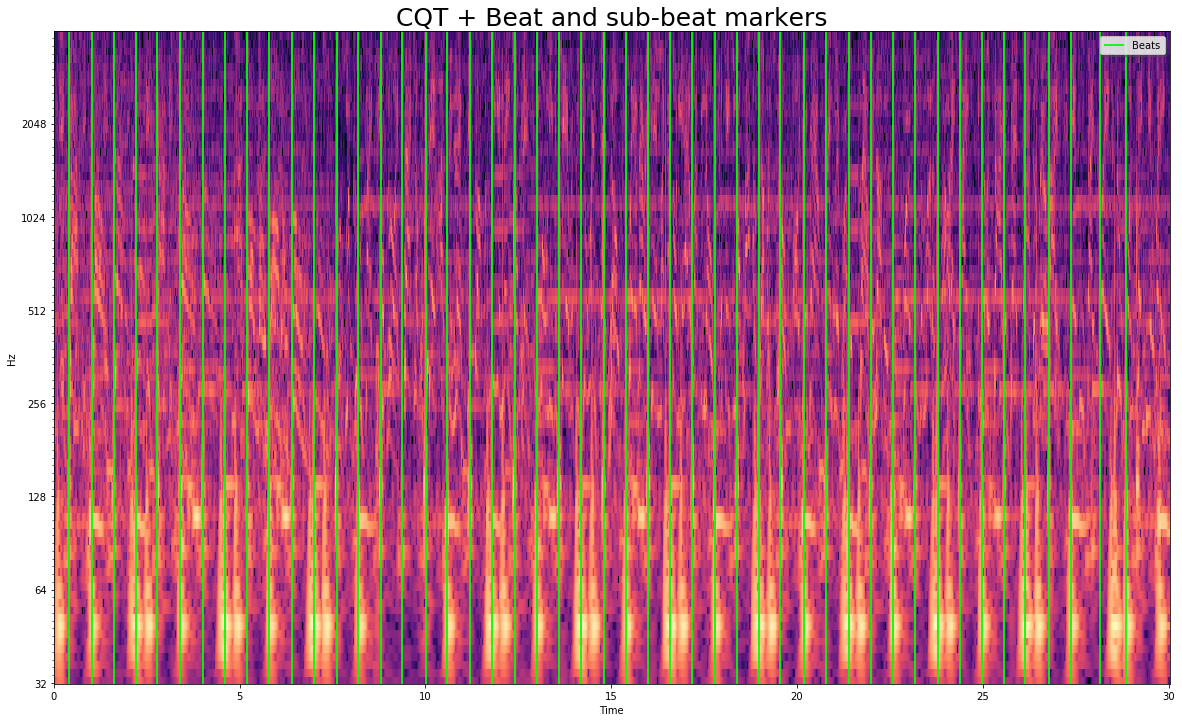

In [6]:
plt.figure(figsize=(20,12))
specshow(librosa.amplitude_to_db(cqt, ref=np.max), y_axis='cqt_hz', x_axis='time')
lims = plt.gca().get_ylim()
plt.vlines(beat_times, lims[0], lims[1], color='lime', alpha=0.9, linewidth=2, label='Beats')
# plt.vlines(subseg_t, lims[0], lims[1], color='linen', linestyle='--',linewidth=1.5, alpha=0.5, label='Sub-beats')
plt.legend(frameon=True, shadow=True)
plt.title('CQT + Beat and sub-beat markers', fontsize=25)
plt.show()

Now we can take manually 2 similar slices and listen to them or show a zoom of their spectrum

In [7]:
step_1 = 4
step_2 = 12

In [8]:
start = int(subseg_t[step_1]*sr)
stop = int(subseg_t[step_1+1]*sr)
ipd.Audio(y[start:stop], rate=sr)

In [9]:
start = int(subseg_t[step_2]*sr)
stop = int(subseg_t[step_2+1]*sr)
ipd.Audio(y[start:stop], rate=sr)

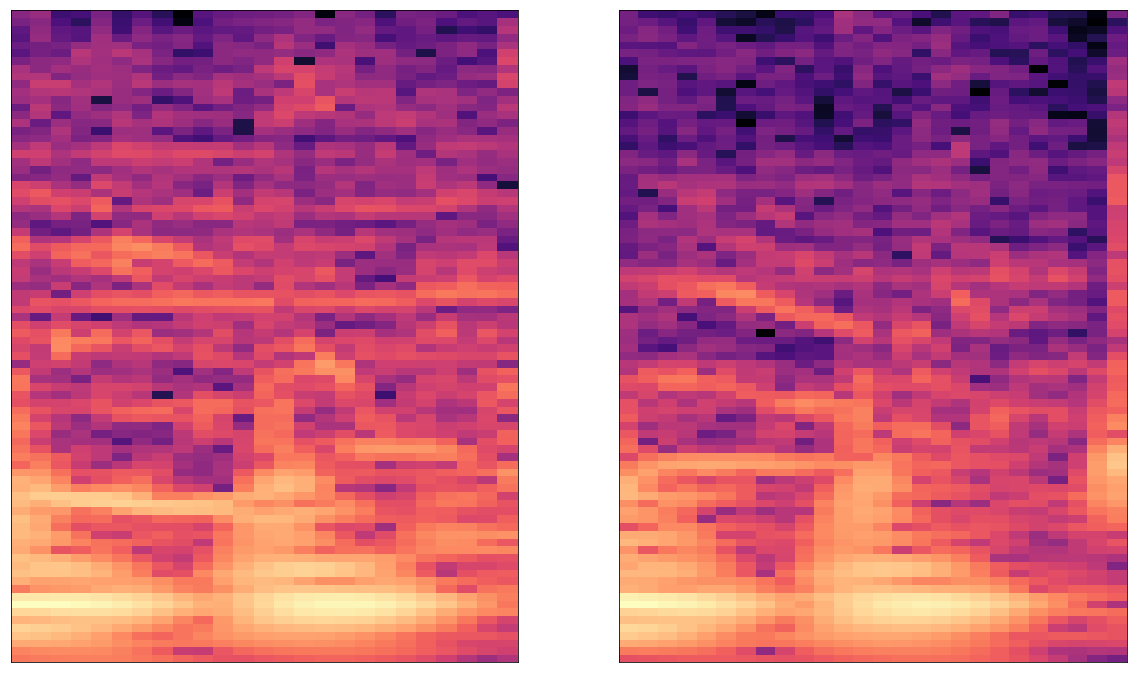

In [10]:
a = cqt[:, subseg[step_1]:subseg[step_1+1]]
b = cqt[:, subseg[step_2]:subseg[step_2+1]]


plt.figure(figsize=(20,12))

plt.subplot(1, 2, 1)
specshow(librosa.amplitude_to_db(a, ref=np.max))

plt.subplot(1, 2, 2)
specshow(librosa.amplitude_to_db(b, ref=np.max))

plt.show()

Of course the sound is very similar as it is the same song. What we can finally do it to reduce this slice to 1 vector of the means along time.
Then we can compute the Jenson Shannon Divergence of the Jaccard distance.

Jenson Shannon Divergence = 0.017563037843781548
Jaccard Distance = 0.11588083787957015


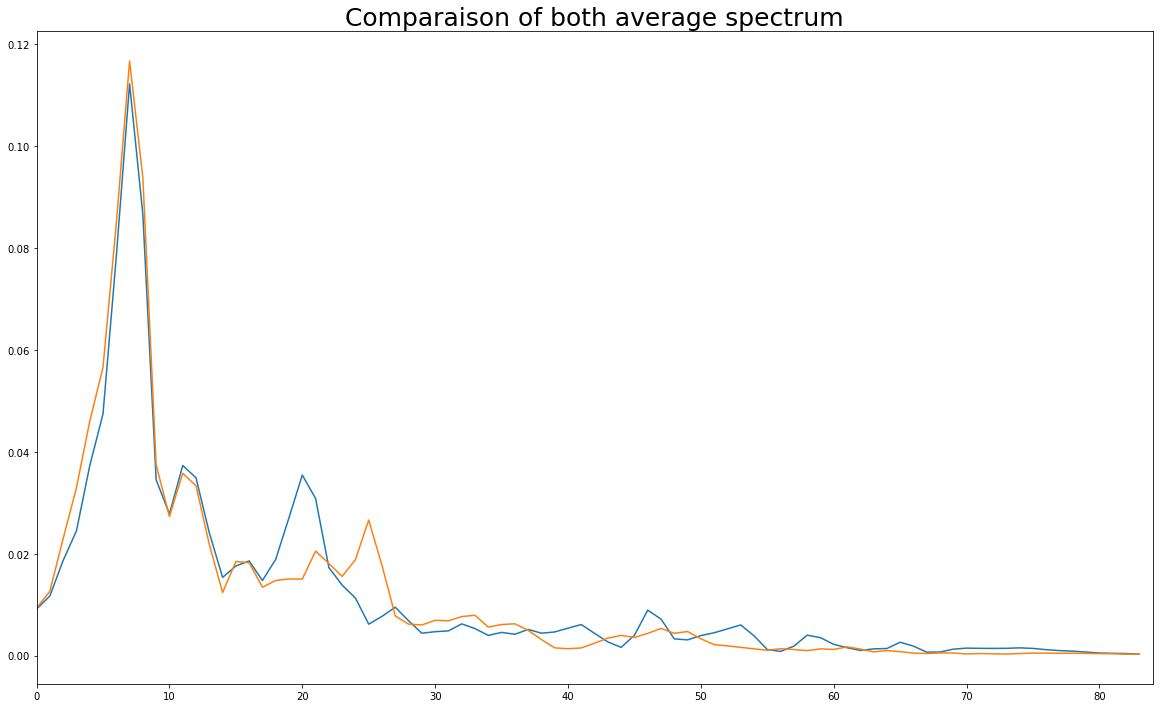

In [11]:
a = a.mean(axis=1)
a_unite = a/a.sum()

b = b.mean(axis=1)
b_unite = b / b.sum()

jsd = JSD(a_unite, b_unite)
jac = jaccard(a_unite, b_unite)
print("Jenson Shannon Divergence =", jsd)
print("Jaccard Distance =", jac)

plt.figure(figsize=(20,12))

plt.plot(a_unite);
plt.plot(b_unite);
plt.title("Comparaison of both average spectrum", fontsize=25)

plt.xlim(0, 84)

plt.show()

# Extraction of features

In [160]:
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None, mono = True)
    id_ = os.path.basename(audio_path)[:-4]
    
    if sr != 44100:
        y = librosa.resample(y, sr, 44100)
        sr = 44100
    
    result = [] 
    key = [] 
    try:
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr, hop_length=1024)
        cqt = np.abs(librosa.cqt(y, sr=sr, hop_length=1024))
        subseg = librosa.segment.subsegment(cqt, beats, n_segments=1)
        for i in range(len(subseg)-1):
            portion = cqt[:, subseg[i]:subseg[i+1]]
            avg_portion = portion.mean(axis=1)  # will be normlized into JSD
            result.append(avg_portion)
            key.append(id_) 
    except:
        print("error on : ", id_)
    
    return key, result

In [ ]:
jump_to = 1000  # top be used to restart at a certain point as we save every 100 sample

X1 = []
X2 = []
for i, audio_path in enumerate(glob.glob("fma_small/*/*.mp3")):
    if i <= jump_to:
        continue
        
    key, vector = extract_features(audio_path)
    X1 += key
    X2 += vector
    if i > 0 and i % 100 == 0:
        df = pd.DataFrame(X2)
        df["song"] = X1
        df = df.set_index("song")
        df.to_csv("preprocessed_audio/mean_cqt/save_{}.csv".format(i//100))
        X1 = []
        X2 = []
df = pd.DataFrame(X2)
df["song"] = X1
df = df.set_index("song")
df.to_csv("preprocessed_audio/mean_cqt/final.csv")

During this phase we got issues with only 3 samples (026600, 114069, 143095). This will not impact too much the model so we can continue as it is. Now let's merge our 80 datasets to a global one.

In [163]:
container = []

for file in glob.glob("preprocessed_audio/mean_cqt/*.csv"):
    container.append(pd.read_csv(file, index_col=0))

pd.concat(container, axis=0).to_csv("preprocessed_audio/mean_cqt.csv")

# Quick Analysis

At this stage we have 456287 vector of the average of subsamples. The idea now is to reduce this 84 diemnsion vector to a cluster number. This will allow us to create a Bag Of Words of features existing in the song. the benefit is to be able to treat any length song, it's quite light as feature extraction as a song will be repreesented as a simple sparse vector.

In [12]:
df = pd.read_csv("preprocessed_audio/mean_cqt.csv", index_col=0)

In [13]:
df.sort_index().head()

0         1         2         3         4         5         6  \
song                                                                         
2     0.945091  1.047913  1.216630  1.267382  1.348611  1.478101  1.452091   
2     1.215588  1.256235  1.356669  1.505153  1.592096  1.656053  1.585883   
2     1.277056  1.227471  1.383451  1.548106  1.554674  1.654062  1.563701   
2     1.330789  1.407587  1.523217  1.705367  1.868914  1.791813  1.678450   
2     0.600035  0.570747  0.613082  0.668417  0.702126  0.765847  0.682961   

             7         8         9    ...           74        75        76  \
song                                  ...                                    
2     1.132619  0.813654  0.669769    ...     0.103227  0.128492  0.097293   
2     1.355786  1.063820  0.957636    ...     0.125441  0.159452  0.133323   
2     1.375511  1.098110  0.947760    ...     0.104220  0.113802  0.092976   
2     1.434612  1.056440  1.039431    ...     0.154206  0.108862  0.085349   
2     0.643105  0.595689  0.603015    ...     0.185708  0.171541  0.145031   

            77        78        79        80        81        82        83  
song                                                                        
2     0.074705  0.066766  0.069670  0.066682  0.073386  0.083000  0.088894  
2     0.097532  0.118680  0.118944  0.113975  0.088847  0.067014  0.059651  
2     0.071940  0.079593  0.099080  0.113258  0.094567  0.076944  0.069156  
2     0.084135  0.107293  0.118544  0.097530  0.101246  0.088209  0.069086  
2     0.113850  0.087925  0.097633  0.124015  0.113214  0.089952  0.072349  

[5 rows x 84 columns]

To do some plot, the best is to have a tidy version. Let's do it just for this

In [14]:
df_tidy = pd.melt(df.reset_index(), id_vars=["song"], value_vars=list(map(str, range(84))))
df_tidy.variable = df_tidy.variable.astype(int)

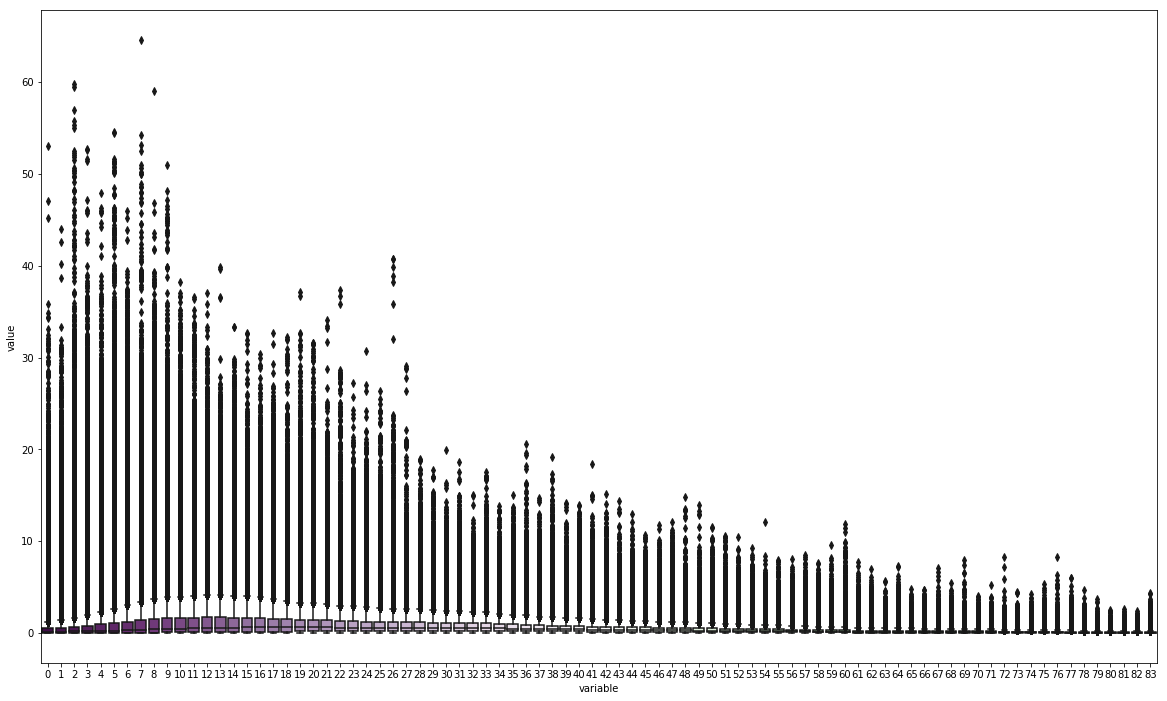

In [15]:
plt.figure(figsize=(20,12))
sns.boxplot(x="variable", y="value", data=df_tidy, palette="PRGn")
plt.show()

[]

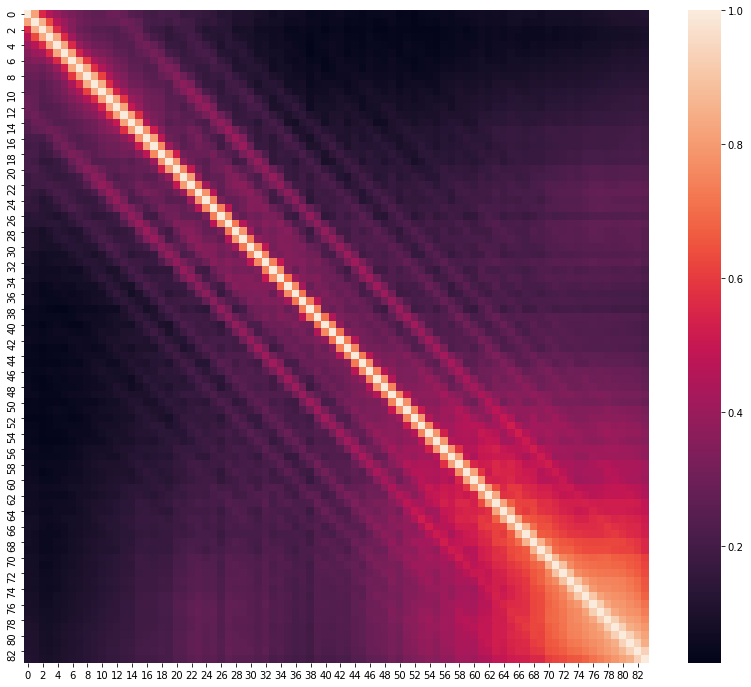

In [17]:
corr = df.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr)
plt.plot()

We can see correlation between frequence which are multiple each other with a smaller value as far as we are from the beginning.

# Clustering

Now we are facing an issue. Vecotrs we have are a distribution based on the frequence. The best distance tu use in that case is Jenson Shannon Divergence of Jaccard. But all clustering algorithm using custom distances require the pairwise distance matrix which would be in our case a 456287 x 456287 float32 matrix which require around 800Gb of Ram... I also tried to implement a kind of DBScan doing online learning but it doesn't work as expected. As a result we will have to stick to the MiniBatch Kmeans which uses Euclidean Distance.

In [19]:
df = pd.read_csv("preprocessed_audio/mean_cqt.csv", index_col=0)
df = df.div(df.sum(axis=1)+1e-6, axis=0)
df = df.dropna(axis=0, how='any')

### Try 1 :

The idea first was to find threshold with the Jaccard Distance (faster to compute). This may be use for the clustering as a max radius of observation.

In [20]:
X = df.as_matrix()

a = X[0, :]
b = X[1, :]

In [21]:
c = np.apply_along_axis(jaccard, axis=1, arr=X, y=a)
d = np.apply_along_axis(jaccard, axis=1, arr=X, y=b)

In [22]:
x = np.linspace(0, 1, 100)
y1 = norm.pdf(x,  np.mean(c), np.std(c))
y2 = norm.pdf(x,  np.mean(d), np.std(d))

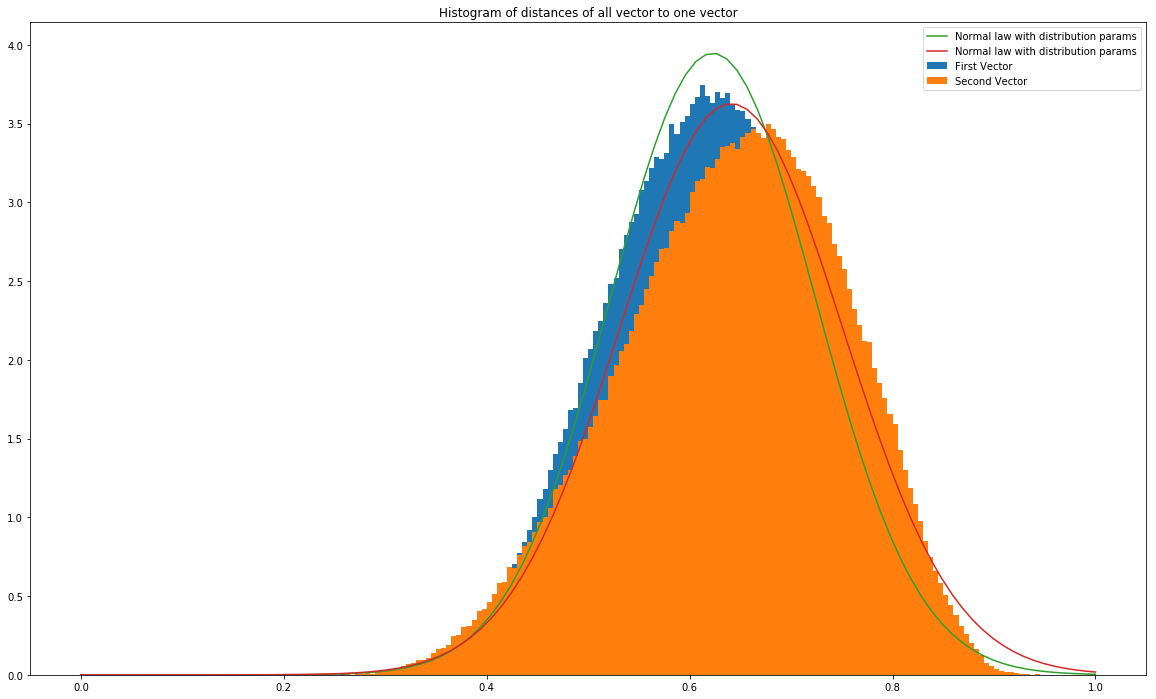

In [24]:
plt.figure(figsize=(20, 12))
plt.hist(c, bins=200, normed=True, label="First Vector")
plt.hist(d, bins=200, normed=True, label="Second Vector")
plt.plot(x, y1, label="Normal law with distribution params")
plt.plot(x, y2, label="Normal law with distribution params")
plt.legend()
plt.title("Histogram of distances of all vector to one vector")
plt.show()

In [25]:
mean = np.mean(c)
std = np.std(c)

norm.cdf(mean - 3.3*std, mean, std)

0.00048342414238377744

0.04 % of observations are below 3.3 x stdev comapre to the second vector (but true in general is the repartition follow normal law). This can be a good threshold as we may ends up with few thousands of clusters which is correct. Let's plot an image of clustered vectors

In [26]:
temp1 = X[np.where(c < np.mean(c) - 3.5 * np.std(c))]
temp2 = X[np.where(d < np.mean(d) - 3.5 * np.std(d))]

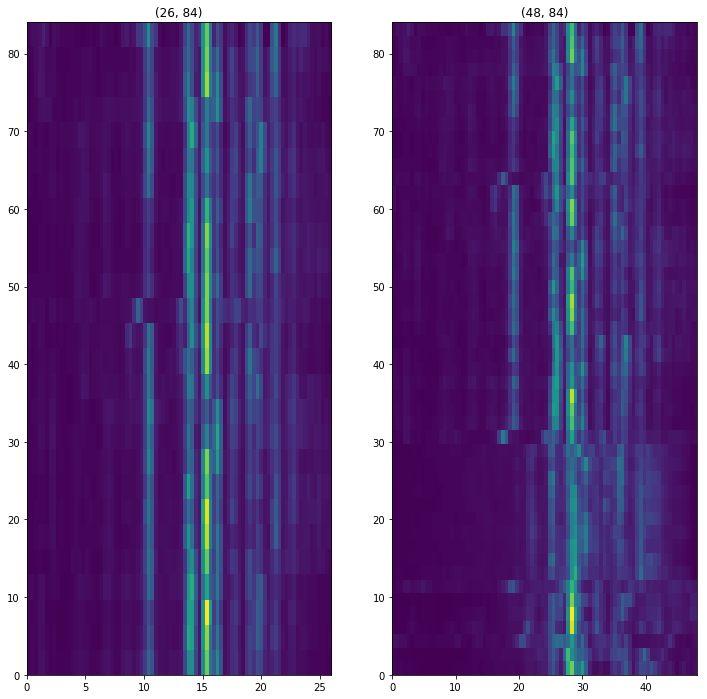

In [28]:
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.imshow(temp1, extent=[0, temp1.shape[0], 0, temp1.shape[1]], aspect='auto');
plt.title(temp1.shape)

plt.subplot(1, 2, 2)
plt.imshow(temp2, extent=[0, temp2.shape[0], 0, temp2.shape[1]], aspect='auto');
plt.title(temp2.shape)
plt.show()

It's correct but clusters are still not perfect we have still important differences

### Try of implementation

In [4]:
df = pd.read_csv("preprocessed_audio/mean_cqt.csv", index_col=0)
df = df.div(df.sum(axis=1)+1e-6, axis=0)
df = df.dropna(axis=0, how='any')

In [5]:
X = df.as_matrix()
X_init = df.as_matrix()

index_list = np.arange(X.shape[0])
cluster_list = np.zeros(X.shape[0])

In [ ]:
cluster_num = 1
while X.shape[0] > 0:
    print("Cluster : {} - Remaining observations : {}".format(cluster_num, X.shape[0]))
    a = X[0 , :]
    b = np.apply_along_axis(jaccard, axis=1, arr=X, y=a)
    mean = np.mean(b)
    std = np.std(b)
    threshold = max(mean - 3 * std, 0.01)
    index_below_threshold = np.where(b < threshold)
    index_above_threshold = np.where(b >= threshold)
    index_cluster = index_list[index_below_threshold]  # store index of similarity distribution
    cluster_list[index_cluster] = cluster_num
    index_list = index_list[index_above_threshold]
    X = X[index_above_threshold]
    cluster_num += 1

This implementation is bad, we have very fast a lot of clusters > 10k and the algorithm is very very slow... few hours for this so I stopped it. We can still after training plot some clustersas we did before

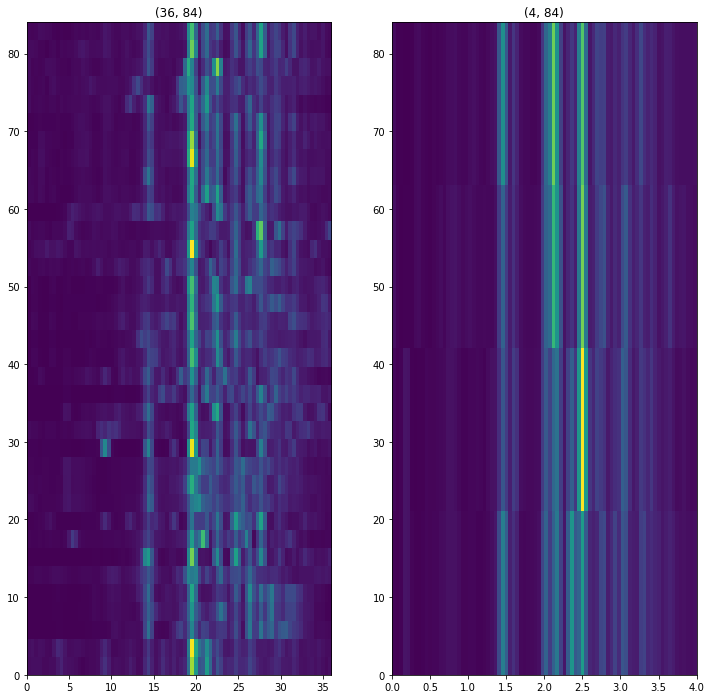

In [140]:
temp1 = X_init[np.where(cluster_list==2)]
temp2 = X_init[np.where(cluster_list==3)]

plt.figure(figsize=(12, 12))

plt.subplot(1, 2, 1)
plt.imshow(temp1, extent=[0, temp1.shape[0], 0, temp1.shape[1]], aspect='auto');
plt.title(temp1.shape)

plt.subplot(1, 2, 2)
plt.imshow(temp2, extent=[0, temp2.shape[0], 0, temp2.shape[1]], aspect='auto');
plt.title(temp2.shape)

plt.show()

### Kmeans

As we mentionned previously, we can use Mini Batch Kmeans but we have to ensure that our clusters are well balanced in term of qty and homogeneous.

In [29]:
df = pd.read_csv("preprocessed_audio/mean_cqt.csv", index_col=0)
df = df.div(df.sum(axis=1)+1e-6, axis=0)
df = df.dropna(axis=0, how='any')

In [30]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=1000, 
                         init='k-means++', 
                         max_iter=30, 
                         batch_size=1000, 
                         verbose=0, 
                         compute_labels=True, 
                         random_state=None
                        )
clusters = kmeans.fit_predict(df)

Now we started with 1000 clusters. Let's look at the content of 2 clusters

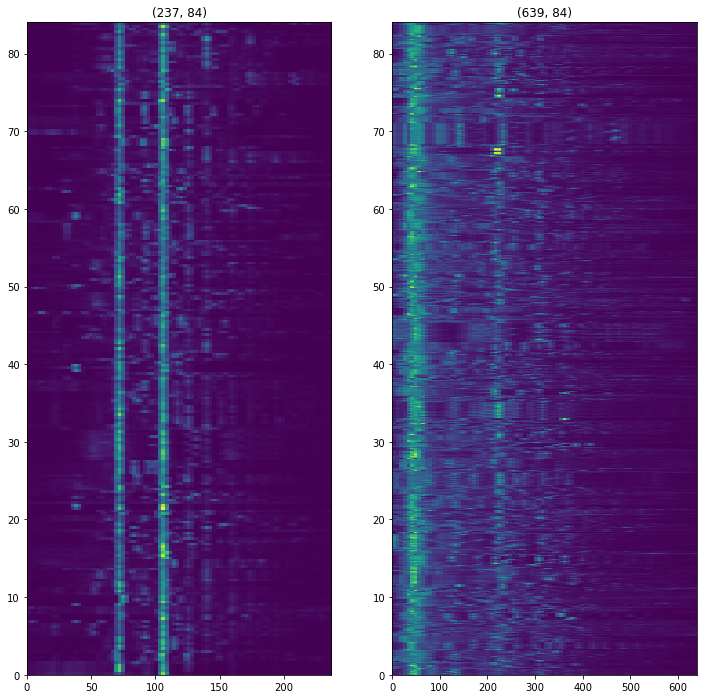

In [31]:
X = df.as_matrix()
temp1 = X[np.where(clusters==999)]
temp2 = X[np.where(clusters==998)]

plt.figure(figsize=(12, 12))

plt.subplot(1, 2, 1)
plt.imshow(temp1, extent=[0, temp1.shape[0], 0, temp1.shape[1]], aspect='auto');
plt.title(temp1.shape)

plt.subplot(1, 2, 2)
plt.imshow(temp2, extent=[0, temp2.shape[0], 0, temp2.shape[1]], aspect='auto');
plt.title(temp2.shape)

plt.show()

One is quite clean but the other one is very noisy and will lead to bad predictions. We can also look at the number of item per cluster and the histogram of this balance

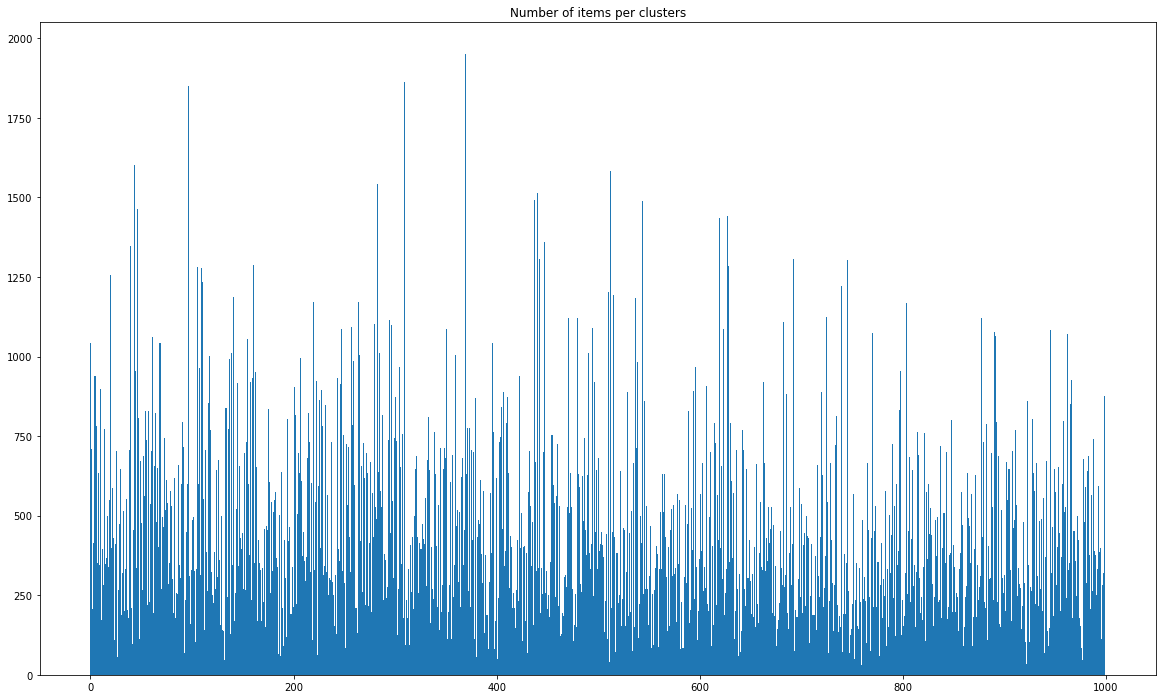

In [40]:
plt.figure(figsize=(20, 12))
a = plt.hist(clusters, bins=999)
plt.title("Number of items per clusters")
plt.show()

We can see that values goes from only few to more than 2000k. Let's see the balance.

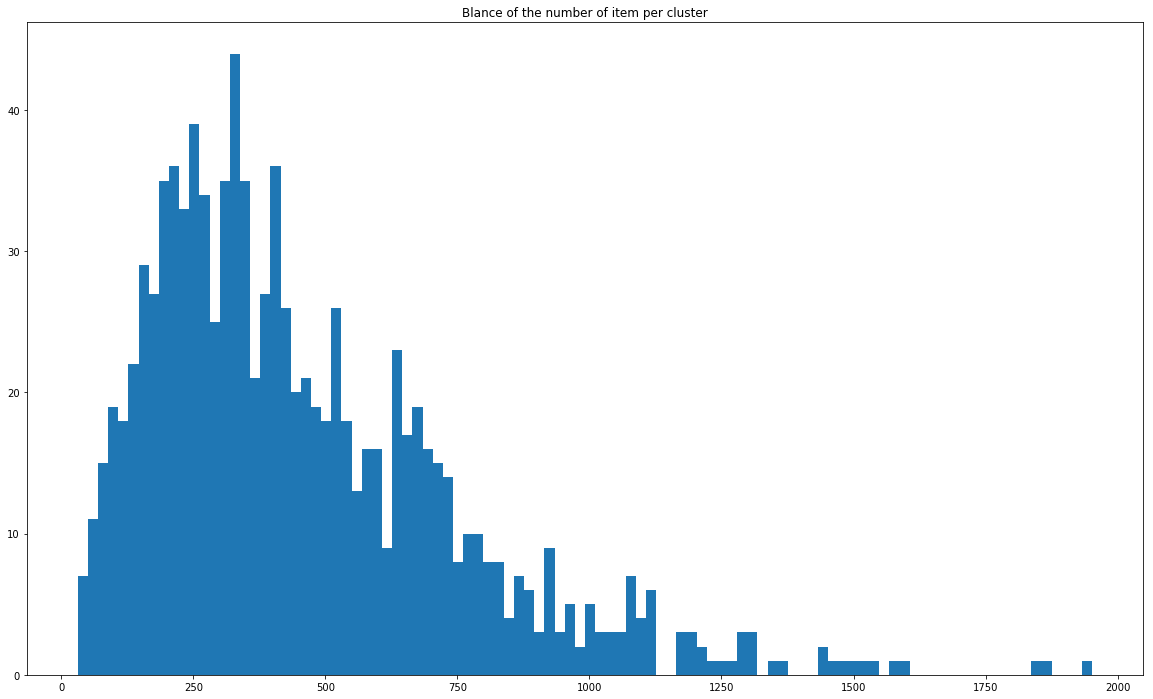

In [46]:
plt.figure(figsize=(20, 12))
plt.hist(a[0], bins=100)
plt.title("Blance of the number of item per cluster")
plt.show()

We can see that we have very big and very small clusters. Maybe we can try another number of clusters. The objective is not to have everytime the same because there is sound we won't find everywhere. But increase this number may improve clustering too. let's try 1500.

C:\python36\envs\machine_learning\lib\site-packages\sklearn\cluster\k_means_.py:1418: RuntimeWarning: init_size=900 should be larger than k=1500. Setting it to 3*k
  init_size=init_size)


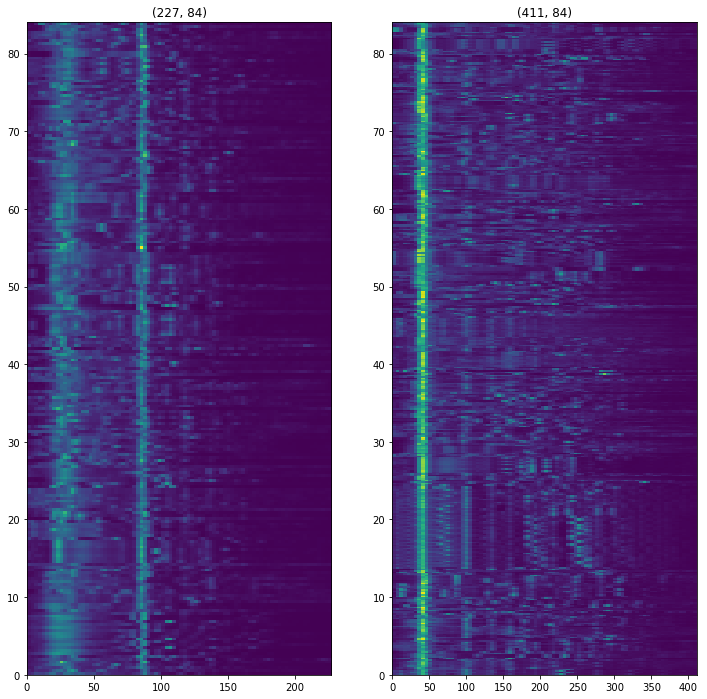

In [50]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=1500, 
                         init='k-means++', 
                         max_iter=30, 
                         batch_size=300, 
                         verbose=0, 
                         compute_labels=True, 
                         random_state=None
                        )
clusters = kmeans.fit_predict(df)

X = df.as_matrix()
temp1 = X[np.where(clusters==999)]
temp2 = X[np.where(clusters==998)]

plt.figure(figsize=(12, 12))

plt.subplot(1, 2, 1)
plt.imshow(temp1, extent=[0, temp1.shape[0], 0, temp1.shape[1]], aspect='auto');
plt.title(temp1.shape)

plt.subplot(1, 2, 2)
plt.imshow(temp2, extent=[0, temp2.shape[0], 0, temp2.shape[1]], aspect='auto');
plt.title(temp2.shape)

plt.show()

Still lot of noise...

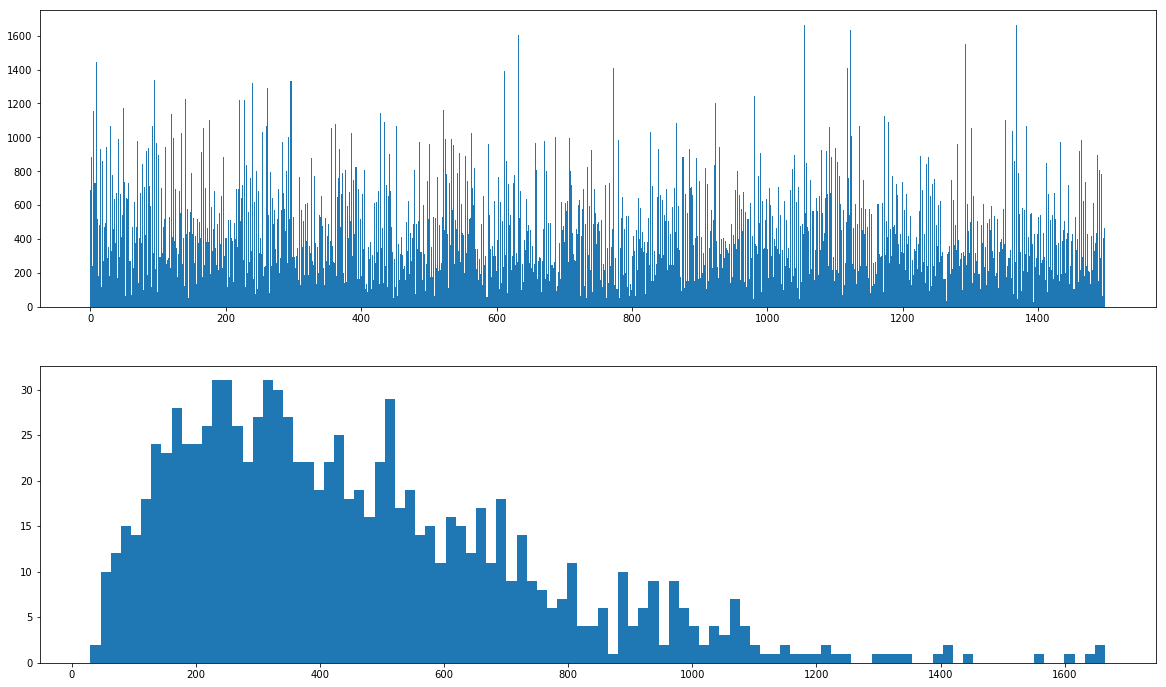

In [54]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 1, 1)
a = plt.hist(clusters, bins=999)
plt.subplot(2, 1, 2)
plt.hist(a[0], bins=100)
plt.show()

So let's train back the model with 1k clusters

In [55]:
kmeans = MiniBatchKMeans(n_clusters=1000, 
                         init='k-means++', 
                         max_iter=30, 
                         batch_size=1000, 
                         verbose=0, 
                         compute_labels=True, 
                         random_state=None
                        )
clusters = kmeans.fit_predict(df)

In [56]:
from sklearn.externals import joblib

joblib.dump(kmeans, 'kmeans.pkl') 

['kmeans.pkl']

Last thing we can do it to check the Jenson Shannon divergence per clusters. This can be done by taking all pairwise distances for every items of every clusters.

In [67]:
dist_vector = pdist(X[np.where(clusters==0)], metric=JSD)
dist_vector2 = pdist(X[np.where(clusters==150)], metric=JSD)

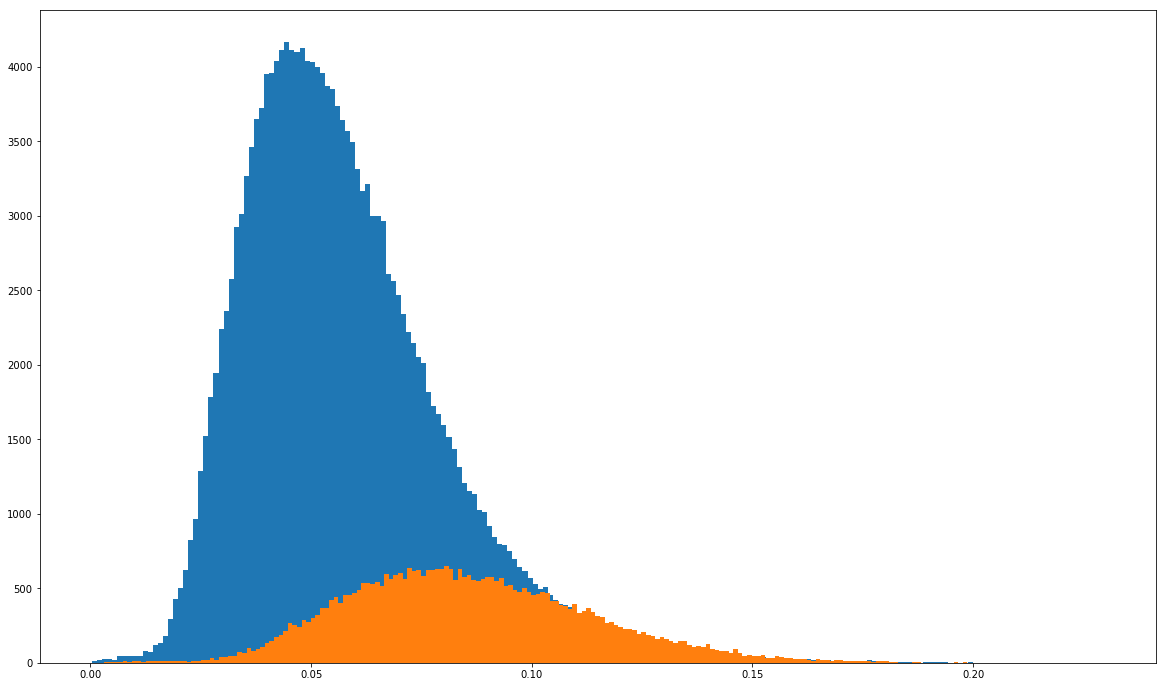

In [68]:
plt.figure(figsize=(20, 12))
plt.hist(dist_vector, bins=200)
plt.hist(dist_vector2, bins=200)
plt.show()

We can see that some cluster are correct(blue one) with a mean of JSD of 0.05 but the case of the cluster 2, the value is 50ù more important... This is where we could improve the clustering but I don't know yet how :(

In [69]:
df["clusters"] = clusters

In [71]:
df[["clusters"]].to_csv("preprocessed_audio/clusters.csv")

# Creation of BoW

In [72]:
df = pd.read_csv("preprocessed_audio/clusters.csv", index_col=0)

In [73]:
ohe = pd.get_dummies(df, columns = ["clusters"])
ohe = ohe.groupby(ohe.index).sum()

In [74]:
ohe.to_csv("preprocessed_audio/sample_content.csv")

In [75]:
ohe[ohe["clusters_10"] > 0].head()

clusters_0  clusters_1  clusters_2  clusters_3  clusters_4  clusters_5  \
song                                                                            
11764           0           0           0           0           0           0   
11766           0           0           0           0           0           0   
11778           0           0           0           0           0           0   
15471           0           0           0           0           0           0   
21891           0           0           0           0           0           0   

       clusters_6  clusters_7  clusters_8  clusters_9      ...       \
song                                                       ...        
11764           0           0           0           0      ...        
11766           0           0           0           0      ...        
11778           0           0           0           0      ...        
15471           0           0           0           1      ...        
21891           0           0           0           0      ...        

       clusters_990  clusters_991  clusters_992  clusters_993  clusters_994  \
song                                                                          
11764             0             0             0             0             0   
11766             0             0             0             0             0   
11778             0             0             0             0             0   
15471             1             0             0             0             0   
21891             0             0             0             0             0   

       clusters_995  clusters_996  clusters_997  clusters_998  clusters_999  
song                                                                         
11764             0             0             0             0             0  
11766             0             0             0             0             0  
11778             0             0             0             0             0  
15471             0             0             0             0             0  
21891             0             0             0             0             0  

[5 rows x 1000 columns]

# Implementation "KNN"

Now let's try to fin d a similar audio to a given audio

In [3]:
df = pd.read_csv("preprocessed_audio/sample_content.csv", index_col=0)

In [4]:
genres = pd.read_csv("preprocessed_meta/genres.csv", index_col=0)
tracks = pd.read_csv("preprocessed_meta/tracks.csv", index_col=0, 
                     encoding="iso-8859-1", 
                     header=[0, 1], 
                     skipinitialspace=True)

In [5]:
df = df.join(tracks[("track", "genre_top")])
df.columns = list(df.columns[:-1]) + ["genres"]

C:\python36\envs\machine_learning\lib\site-packages\pandas\core\reshape\merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [6]:
df.head()

clusters_0  clusters_1  clusters_2  clusters_3  clusters_4  clusters_5  \
song                                                                           
2              0           0           0           0           0           0   
5              0           0           0           0           0           0   
10             0           0           0           0           0           0   
140            0           0           0           0           0           0   
141            0           0           0           0           0           0   

      clusters_6  clusters_7  clusters_8  clusters_9   ...     clusters_991  \
song                                                   ...                    
2              2           0           0           0   ...                0   
5              0           0           0           0   ...                0   
10             0           0           0           0   ...                0   
140            0           0           0           0   ...                0   
141            0           0           0           0   ...                0   

      clusters_992  clusters_993  clusters_994  clusters_995  clusters_996  \
song                                                                         
2                0             0             0             0             0   
5                0             0             0             0             2   
10               0             0             0             0             0   
140              4             0             0             0             0   
141              0             0             0             0             0   

      clusters_997  clusters_998  clusters_999   genres  
song                                                     
2                0             0             0  Hip-Hop  
5                0             0             0  Hip-Hop  
10               0             0             0      Pop  
140              0             0             0     Folk  
141              0             0             0     Folk  

[5 rows x 1001 columns]

We have a BoW. In theroy the best would be to use cosine similarity but this doesn't work. As a result, we will use the cityblock distance on normalised BoW.

In [80]:
X = df.drop("genres", axis=1)

In [81]:
X2 = X.div(X.sum(axis=1)+1e-6, axis=0)
distance_matrix = pairwise_distances(X2, X2, metric='cityblock', n_jobs=-1)

Let's see distances between 1 sample song to the all other one.

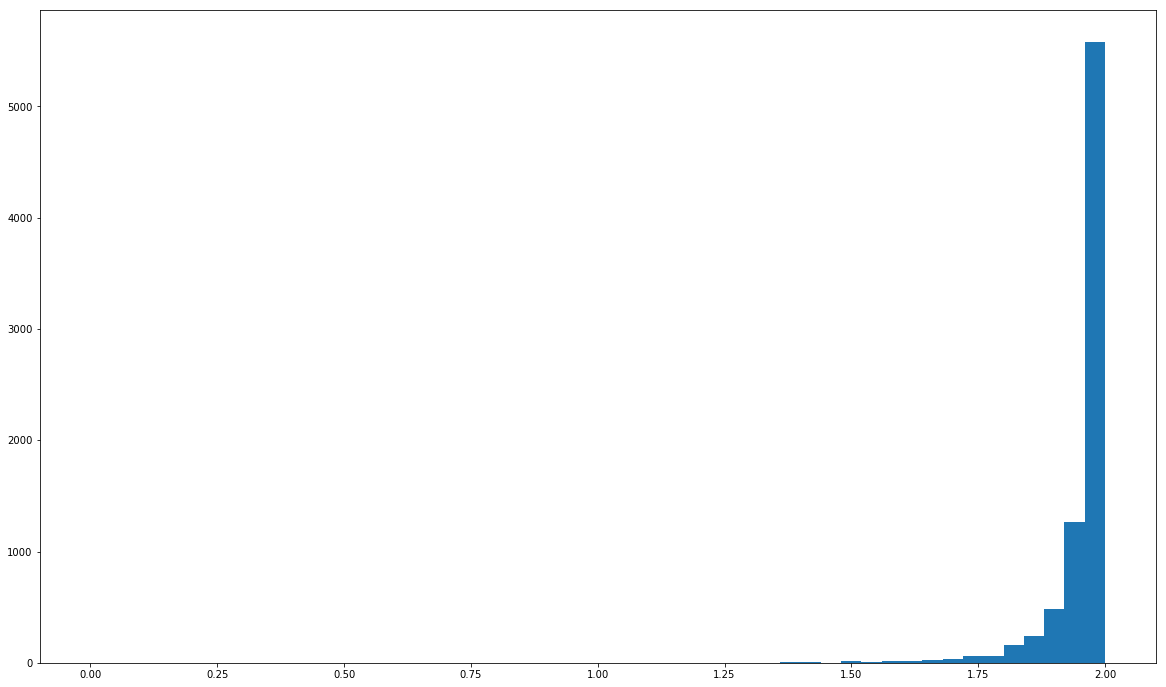

In [85]:
plt.figure(figsize=(20, 12))
plt.hist(distance_matrix[0], bins = 50)
plt.show()

Most of song doesn't share any values so we have a distance of 2. Let's look only to the closest one. 

In [86]:
index_1 = 2
index_2 = np.argsort(distance_matrix[index_1, :])[1]
song_1 = df.iloc[[index_1]].index.values[0]
song_2 = df.iloc[[index_2]].index.values[0]

distance_matrix[index_1, index_2]

0.8837209238458134

Minimum distance is 0.88... not very good but listen now the 2 songs

In [87]:
song_id = "{0:06d}".format(song_1)
folder = song_id[:3]

y, sr = librosa.load("fma_small/"+folder+"/"+song_id+".mp3", sr=None, mono = True)

if sr != 44100:
    y = librosa.resample(y, sr, 44100)
    sr = 44100
    
print(song_id)
ipd.Audio(y[:1000000], rate=sr)

000010


In [88]:
song_id = "{0:06d}".format(song_2)
folder = song_id[:3]

y, sr = librosa.load("fma_small/"+folder+"/"+song_id+".mp3", sr=None, mono = True)

if sr != 44100:
    y = librosa.resample(y, sr, 44100)
    sr = 44100
    
print(song_id)
ipd.Audio(y[:1000000], rate=sr)

013749


Hum... we can hear some similar sound but the global song is quite far from here. maybe more song and a smaller decomposition of every song would help to solve this defect.

# Test of Classifier

In [11]:
df = pd.read_csv("preprocessed_audio/sample_content.csv", index_col=0)

tracks = pd.read_csv("preprocessed_meta/tracks.csv", index_col=0, 
                     encoding="iso-8859-1", 
                     header=[0, 1], 
                     skipinitialspace=True)

df = df.join(tracks[("track", "genre_top")])
df.columns = list(df.columns[:-1]) + ["genres"]

X = df.drop("genres", axis=1).as_matrix()

enc = LabelEncoder()
y_enc = enc.fit_transform(df.genres.values)

C:\python36\envs\machine_learning\lib\site-packages\pandas\core\reshape\merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [16]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
tfidf = transformer.fit_transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.20, random_state=42)

In [19]:
X_train.dtype

dtype('int64')

First I wanted to try dimensionnality reduction using PCA of LDA/LSA without good result. So to try classifier, let's first compute the TF-IDF instead of only tf and try few models on this matrix.

In [18]:
clf = SVC()
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.556686501722518
0.3807138384470883


In [35]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 50, max_depth=8)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.4301597243971187
0.30932999373825926


In [36]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.4337613529595991
0.35879774577332496


Surprisingly, we have a very sparse matrix of 8000 x 1000 and we are still able to not overfit too much. This is a good point.

# Conclusion

Compare to the previous Notebbok, this one is more focused on classical approach by clustering music like we do with text. Then we can apply apply all methods from text mining instead of immage processing. It has very good benefits. First we can do online learning as we can process all new song in a very simple ways. We can also understand what a specific user like of don't like by applying reinforcement method (if they swap the song, we can remove points for every precedent bucket with a discount factor).

Result of classification are lower than the previous method with around 35% of correct result. This hasn't been digged as we knew upfront that our model has defect. The main one is the clustering. I don't know a good way to perform the clustering on such a huge dataset with custom distance. In the next workbook, we will use another approach to segment the audio by using Semi Hidden Markov Models.